# Evaluate performance

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from scipy.stats import pearsonr, randint, uniform

import matplotlib.pyplot as plt
import matplotlib.cm

In [37]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [47]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [3]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [4]:
# DEMAND_FILE = "daily_demand_2010-2020_stl.nc"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
# REGION = "NSW"

In [7]:
# REMOVE_WEEKEND = False

In [8]:
# REMOVE_XMAS = False

In [9]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [10]:
# MASK_NAME = "pop_dens_mask"

In [11]:
TIME_COLUMNS = ["is_weekend"]

In [12]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2016

In [13]:
FIRST_TEST_YEAR = 2017
LAST_TEST_YEAR = 2019

### Load model results

In [14]:
def get_filename(
    filename, market, region, mask_name,
    first_train_year, last_train_year, first_test_year, last_test_year,
    weekend=False, xmas=False, month=None
):
    """
    Return a filename appropriate for the modelling choices made.
    """
    filename = filename + "_" + market + "_" + region + "_" + mask_name
    if weekend:
        filename += "_NOWEEKEND"
    if xmas:
        filename += "_NOXMAS"
    if month > 0:
        filename = filename + "_NOMONTH" + str(month)
        
    filename =  filename + "_training" + str(first_train_year) + "-" + str(last_train_year)
    filename = filename + "_test" + str(first_test_year) + "-" + str(last_test_year)
    
    return filename

### Read feature data

In [15]:
def read_feature_results(mask_name, rm_weekend, rm_xmas):
    """
    Read in feature selection dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = get_filename(
            "feature_selection_results", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "feature_selection/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [18]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

In [21]:
# Population density mask, all data
features_dict = read_feature_results("pop_dens_mask", False, False)

In [20]:
features_dict["NSW"].head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(15,)",[-12032.12634008 -12709.37474908 -11388.006184...,-11633.182289,['hdd3'],659.204486,682.863092,278.777690
2,"(0, 15)",[-8780.50068176 -9163.20407944 -8380.05594135 ...,-8428.676304,"['is_weekend', 'hdd3']",456.297902,472.674265,192.968461
3,"(0, 3, 15)",[-6546.42224014 -6888.74937117 -5695.42862145 ...,-6312.857300,"['is_weekend', 'msdwswrf', 'hdd3']",382.056762,395.768638,161.571870
4,"(0, 3, 15, 16)",[-5494.42170587 -5813.28549908 -4874.62556786 ...,-5406.481065,"['is_weekend', 'msdwswrf', 'hdd3', 't2m']",342.686297,354.985182,144.922094
5,"(0, 3, 8, 15, 16)",[-5381.71894911 -5695.40491658 -4958.46416182 ...,-5251.839213,"['is_weekend', 'msdwswrf', 't2max', 'hdd3', 't...",307.196164,318.221321,129.913310


In [22]:
# No mask, all data
features_no_mask_dict = read_feature_results("no_mask", False, False)

In [23]:
# Log(population density) mask, all data
features_log_mask_dict = read_feature_results("pop_dens_log_mask", False, False)

In [24]:
# Population density mask, remove weekends and Xmas
features_no_wknd_no_xmas_dict = read_feature_results("pop_dens_mask", True, True)

In [136]:
def plot_feature_selection(ax, results, label, col1="tab:blue", col2="tab:red"):
    """
    Plot average score +/- standard deviation
    
    ax: axes
    result: pandas dataframe with avg_score and std_dev columns
    """
    avg_score = results["avg_score"].values
    std = results["std_dev"].values
    score_max = np.where(avg_score == np.max(avg_score))[0][0]
    
    p = ax.plot(avg_score, marker="o", c=col1, zorder=1, label=label)
    ax.fill_between(range(len(std)), avg_score + std, avg_score - std, alpha=0.3, color=col1, zorder=1)
    ax.scatter(range(len(avg_score))[score_max], avg_score[score_max], zorder=2, c=col2)
    
    ax.axes.grid(zorder=0)
    ax.set_axisbelow(True)
    ax.set_xticks(range(len(avg_score)))
    ax.set_xticklabels(range(1, len(avg_score) + 1))
    ax.set_xlabel("Number of features")
    ax.set_ylabel("neg_mean_absolute_error")
    
    return p

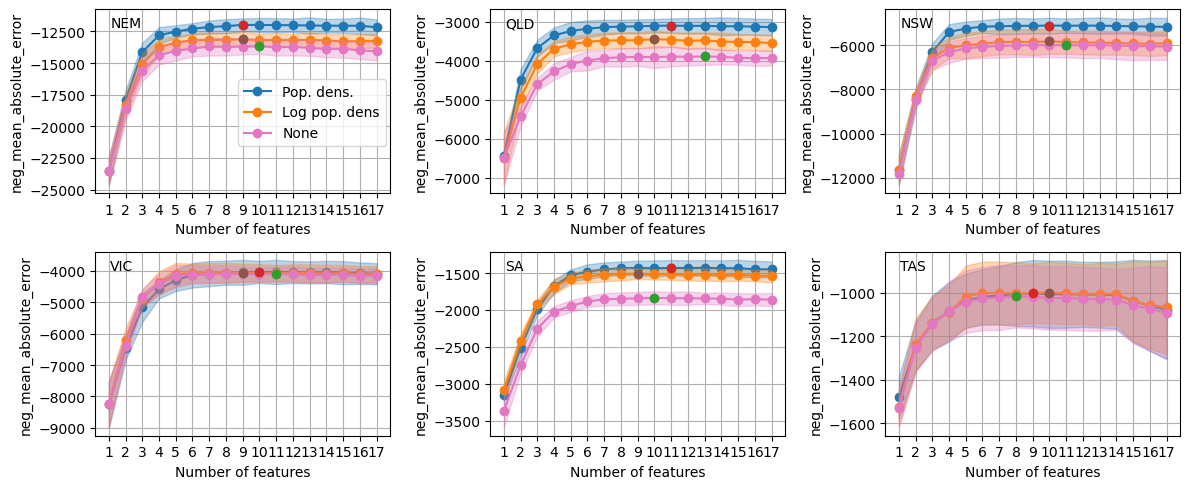

In [142]:
fig, ax = plt.subplots(2, 3, figsize=(12,5))
for i, r in enumerate(regions):
    p1 = plot_feature_selection(ax.flatten()[i], features_dict[r], "Pop. dens.")
    p2 = plot_feature_selection(ax.flatten()[i], features_log_mask_dict[r], "Log pop. dens", col1="tab:orange", col2="tab:brown")
    p3 = plot_feature_selection(ax.flatten()[i], features_no_mask_dict[r], "None", col1="tab:pink", col2="tab:green")
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
handles, labels = ax.flatten()[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2, 0.7))
    
plt.tight_layout()

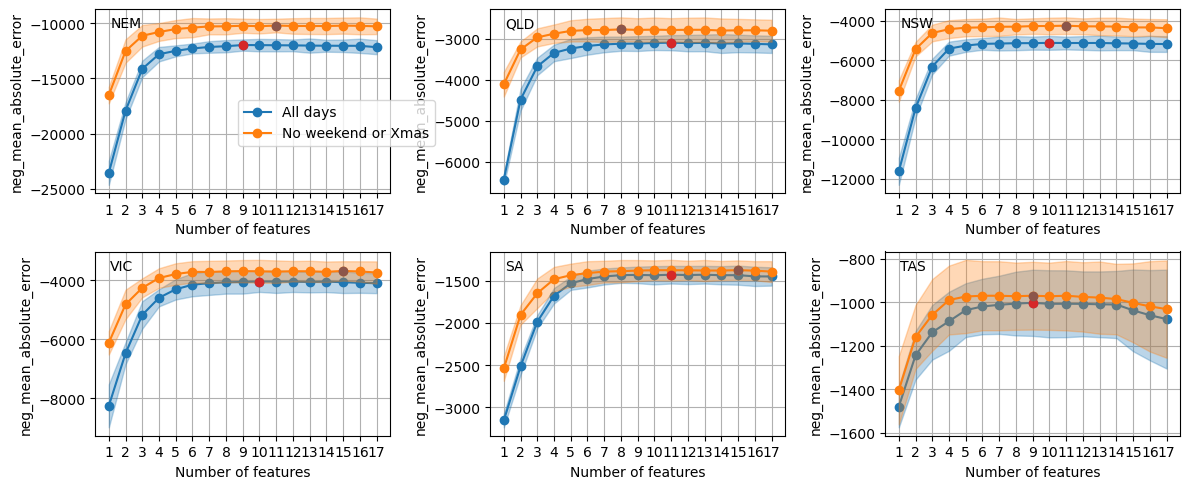

In [144]:
fig, ax = plt.subplots(2, 3, figsize=(12,5))
for i, r in enumerate(regions):
    p1 = plot_feature_selection(ax.flatten()[i], features_dict[r], "All days")
    p2 = plot_feature_selection(ax.flatten()[i], features_no_wknd_no_xmas_dict[r], "No weekend or Xmas", col1="tab:orange", col2="tab:brown")
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
handles, labels = ax.flatten()[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2, 0.7))
    
plt.tight_layout()

# Hyperparameters

In [25]:
def read_hyperparameter_results(mask_name, rm_weekend, rm_xmas):
    """
    Read in feature selection dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = get_filename(
            "hyperparameters", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "hyperparameters/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [26]:
# Population density mask, all data
hyperparameters_dict = read_hyperparameter_results("pop_dens_mask", False, False)

In [29]:
# Population density mask, remove weekends and Xmas
hyperparameters_no_wknd_no_xmas_dict = read_hyperparameter_results("pop_dens_mask", True, True)

In [30]:
hyperparameters_dict

{'NEM':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'QLD':                     0
 max_depth          21
 max_leaf_nodes    156
 min_samples_leaf    6
 n_estimators      409,
 'NSW':                     0
 max_depth          28
 max_leaf_nodes    150
 min_samples_leaf    7
 n_estimators      262,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          13
 max_leaf_nodes    174
 min_samples_leaf    7
 n_estimators      448}

In [31]:
hyperparameters_no_wknd_no_xmas_dict

{'NEM':                     0
 max_depth          46
 max_leaf_nodes    130
 min_samples_leaf    5
 n_estimators      273,
 'QLD':                     0
 max_depth          10
 max_leaf_nodes    163
 min_samples_leaf   10
 n_estimators      237,
 'NSW':                     0
 max_depth          10
 max_leaf_nodes    114
 min_samples_leaf    5
 n_estimators      378,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          21
 max_leaf_nodes    156
 min_samples_leaf    6
 n_estimators      409}

# Prediction skill

### Load predictions and observations

In [178]:
def read_training_results(mask_name, rm_weekend, rm_xmas):
    """
    Read in training set observations and predictions dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = get_filename(
            "training_predictions", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "training/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [70]:
def read_test_results(mask_name, rm_weekend, rm_xmas):
    """
    Read in test set observations and predictions dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = get_filename(
            "test_predictions", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "test/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [71]:
# Population density mask, all data
training_dict = read_training_results("pop_dens_mask", False, False)
test_dict = read_test_results("pop_dens_mask", False, False)

In [72]:
# Population density mask, remove weekends and Xmas
training_no_wknd_no_xmas_dict = read_training_results("pop_dens_mask", True, True)
test_no_wknd_no_xmas_dict = read_test_results("pop_dens_mask", True, True)

In [54]:
metric_names = ["r", "R2", "MAE", "MSE", "MAPE", "MedAE"]

In [53]:
# scikit learn metrics (correlation will be computed too, within fn.compute_scores)
sklearn_metrics = [
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error
]

In [66]:
def get_scores(res_dict, metrics, metric_names):
    """
    Compute the scores for each region in res_dict.
    """
    df = pd.DataFrame(index=res_dict.keys(), columns=metric_names)
    for r in res_dict.keys():
        scores = fn.compute_scores(res_dict[r]["observation"], res_dict[r]["prediction"], metrics)
        df.loc[r] = [scores[i] for i in range(-1, 5)]
    return df

In [68]:
training_scores = get_scores(training_dict, sklearn_metrics, metric_names)

In [69]:
training_no_wknd_no_xmas_scores = get_scores(training_no_wknd_no_xmas_dict, sklearn_metrics, metric_names)

In [73]:
test_scores = get_scores(test_dict, sklearn_metrics, metric_names)

In [74]:
test_no_wknd_no_xmas_scores = get_scores(test_no_wknd_no_xmas_dict, sklearn_metrics, metric_names)

In [75]:
training_scores

,r,R2,MAE,MSE,MAPE,MedAE
NEM,0.932034,0.866484,9521.779598,175505934.066376,0.018473,7577.281052
QLD,0.934684,0.871975,2411.568204,11305185.13728,0.016712,1913.534623
NSW,0.935877,0.874274,4176.712923,34032029.159641,0.021875,3282.102497
VIC,0.940936,0.88285,3160.025575,18671038.447404,0.0256,2489.066463
SA,0.955216,0.90952,1121.985758,2175868.897163,0.034057,915.514437
TAS,0.909152,0.82369,788.417921,1036966.86835,0.029926,636.741106


In [76]:
test_scores

,r,R2,MAE,MSE,MAPE,MedAE
NEM,0.90781,0.820572,11918.733227,263079397.714663,0.022613,9218.617925
QLD,0.934886,0.856219,3405.325106,20565655.214637,0.022661,2617.593909
NSW,0.925385,0.8507,4801.506709,47556983.123422,0.024292,3445.479907
VIC,0.905771,0.816786,4289.530688,33410981.322426,0.03429,3298.42303
SA,0.926492,0.856454,1584.795002,4069031.11206,0.047153,1334.424447
TAS,0.882047,0.775137,957.332805,1443970.644378,0.035947,794.227194


In [176]:
def barplot(ax, metric):
    """
    Barplot of metric for each region
    """
    x = range(17)

    y = np.full(17, np.nan)
    y[[0, 3, 6, 9, 12, 15]] = training_scores[metric]
    y[[1, 4, 7, 10, 13, 16]] = test_scores[metric]

    colors = [matplotlib.cm.get_cmap("Pastel2")(j) for j in range(6) for _ in range(3)]

    ax.bar(x, y, color=colors)
    
    xticks = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16]
    ax.set_xticks(xticks)
    ax.set_xticklabels(["Train", "Test"] * 6, rotation=45)
    
    ax.set_ylabel(metric)

    # for ix, r in zip([xticks[i] for i in range(0, len(xticks), 2)], training_scores.index):
    #     ax.text(ix, -0.15, r)
    
    for ix, r in zip([0.04, 0.2, 0.35, 0.54, 0.71, 0.87], training_scores.index):
        ax.text(ix, -0.35, r, transform=ax.transAxes)

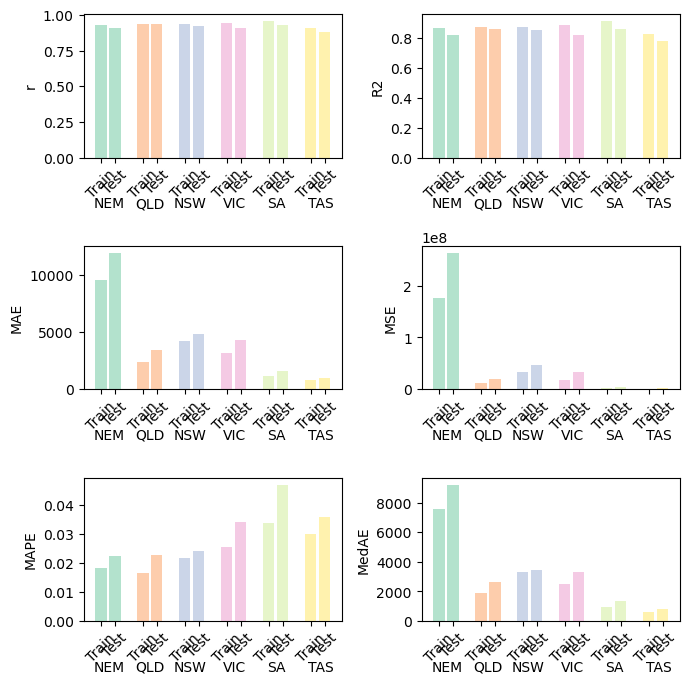

In [177]:
fig, ax = plt.subplots(3, 2, figsize=(7, 7))

for i, m in enumerate(metric_names):
    barplot(ax.flatten()[i], m)
    
plt.tight_layout()

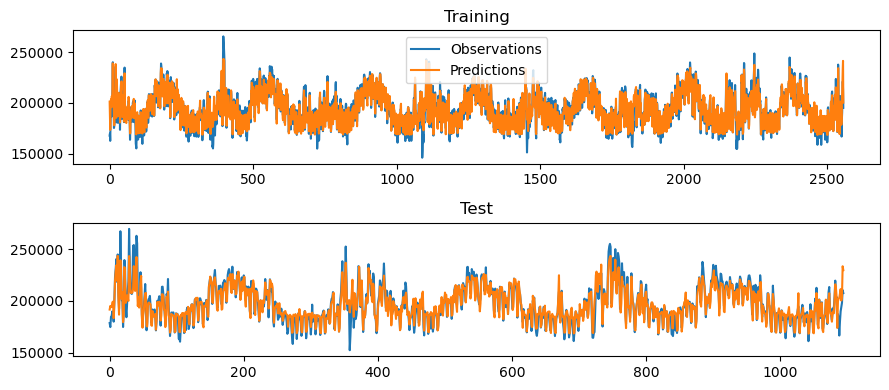

In [84]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

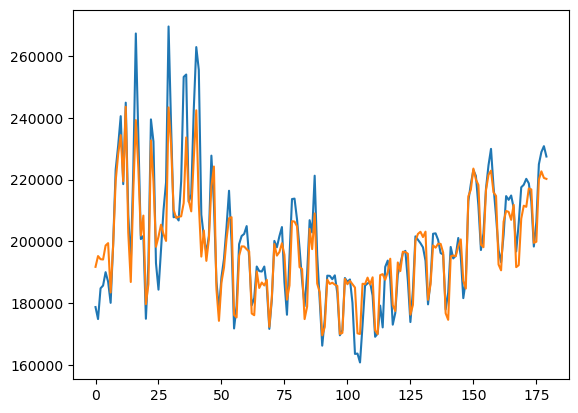

In [85]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [78]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=200,
)

In [79]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=200,
)

In [80]:
perm_train

{'importances_mean': array([0.13995164, 0.01626925, 0.10572489, 0.07931434, 0.05082711,
        0.11471596, 0.02440561, 0.00493057, 0.03010124, 0.01219024]),
 'importances_std': array([0.00767917, 0.00085208, 0.00473147, 0.00350224, 0.00266331,
        0.00494296, 0.00123989, 0.00032476, 0.00184531, 0.00062019]),
 'importances': array([[0.13823381, 0.14006429, 0.13473595, ..., 0.14147323, 0.15898924,
         0.14590845],
        [0.01666628, 0.01584424, 0.01472775, ..., 0.01520337, 0.01683122,
         0.01746151],
        [0.09569864, 0.10335834, 0.11467901, ..., 0.10444087, 0.09852746,
         0.10132439],
        ...,
        [0.00420485, 0.00487804, 0.00512109, ..., 0.00493622, 0.00463681,
         0.00488321],
        [0.02698144, 0.03150382, 0.03180216, ..., 0.03053448, 0.0288593 ,
         0.03003869],
        [0.01080903, 0.01258779, 0.01293996, ..., 0.01263043, 0.01205979,
         0.01205937]])}

In [81]:
perm_test

{'importances_mean': array([0.07746051, 0.00150864, 0.11290801, 0.06718211, 0.01717762,
        0.11936247, 0.00826919, 0.00018062, 0.02204301, 0.00619968]),
 'importances_std': array([0.00894955, 0.00101213, 0.00718671, 0.00447685, 0.00376282,
        0.00779727, 0.00141239, 0.00031644, 0.00335353, 0.00105301]),
 'importances': array([[ 7.85418244e-02,  7.94944138e-02,  7.75581507e-02, ...,
          7.40198859e-02,  7.20541268e-02,  7.35219301e-02],
        [ 2.74295163e-03,  1.16625889e-03, -9.18489994e-05, ...,
          2.88342405e-03,  1.37960546e-03,  1.84245141e-03],
        [ 1.17367972e-01,  1.15038405e-01,  1.17089528e-01, ...,
          9.82815625e-02,  9.94207390e-02,  1.18130334e-01],
        ...,
        [-4.57788609e-04,  3.76797985e-04, -3.18489614e-05, ...,
          4.30664278e-04,  1.58781701e-04,  4.43500560e-04],
        [ 2.41954804e-02,  2.37801136e-02,  2.25581075e-02, ...,
          2.06896959e-02,  2.22267538e-02,  2.19887514e-02],
        [ 7.13391174e-03,  

In [82]:
fn.print_perm_imp(perm_train, selected_features)

is_weekend 0.140 +/- 0.008
t2max    0.115 +/- 0.005
t2m      0.106 +/- 0.005
t2m3     0.079 +/- 0.004
w10      0.051 +/- 0.003
cdd3     0.030 +/- 0.002
msdwswrf 0.024 +/- 0.001
q        0.016 +/- 0.001
cdd4     0.012 +/- 0.001
mtpr     0.005 +/- 0.000


In [83]:
fn.print_perm_imp(perm_test, selected_features)

t2max    0.119 +/- 0.008
t2m      0.113 +/- 0.007
is_weekend 0.077 +/- 0.009
t2m3     0.067 +/- 0.004
cdd3     0.022 +/- 0.003
w10      0.017 +/- 0.004
msdwswrf 0.008 +/- 0.001
cdd4     0.006 +/- 0.001
